<a href="https://colab.research.google.com/github/Arta-DS/DS/blob/main/%D0%90%D1%80%D1%85%D0%B8%D1%82%D0%B5%D0%BA%D1%82%D1%83%D1%80%D1%8B_%D1%81%D0%B2%D1%91%D1%80%D1%82%D0%BE%D1%87%D0%BD%D1%8B%D1%85_%D1%81%D0%B5%D1%82%D0%B5%D0%B9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

In [42]:
# 1. Настройка устройства (GPU/CPU)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Используется устройство: {device}')

Используется устройство: cpu


In [51]:
# 2. Загрузка и предварительная обработка данных EMNIST
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1751,), (0.3332,))
])

train_dataset = torchvision.datasets.EMNIST(
    root='./data', split='letters', train=True, download=True, transform=transform
)
test_dataset = torchvision.datasets.EMNIST(
    root='./data', split='letters', train=False, download=True, transform=transform
)

#Создаём подвыборку ТОЛЬКО для обучения
subset_size = 8000
small_train_dataset = torch.utils.data.Subset(train_dataset, list(range(subset_size)))

#Используем ПОДВЫБОРКУ для train_loader
batch_size = 64
train_loader = DataLoader(small_train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

num_classes = len(train_dataset.classes) - 1
print(f'Количество классов: {num_classes}')

Количество классов: 26


In [52]:
# 3. Функция для получения готовой модели из torchvision
def get_model(model_name, num_classes):
    if model_name == "ResNet18":
        model = torchvision.models.resnet18(weights=None)
        # Меняем первый слой: 1 входной канал вместо 3
        model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        # Меняем классификатор под 26 классов
        model.fc = nn.Linear(model.fc.in_features, num_classes)
        return model.to(device)

In [53]:
# 4. Функция для обучения модели
def train_model(model, train_loader, criterion, optimizer, num_epochs=10):
    model.train()
    train_losses = []

    for epoch in range(num_epochs):
        running_loss = 0.0
        for i, (images, labels) in enumerate(train_loader):
            # Для EMNIST Letters метки начинаются с 1, приводим к 0-индексации
            labels = labels - 1
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        epoch_loss = running_loss / len(train_loader)
        train_losses.append(epoch_loss)
        print(f'Эпоха [{epoch+1}/{num_epochs}], Потери: {epoch_loss:.4f}')

    return train_losses

In [54]:
# 5. Проведение экспериментов
model_names = ["ResNet18"]
results = {}
num_epochs = 10

for name in model_names:
    print(f"\nОбучение модели: {name}")
    try:
        model = get_model(name, num_classes)
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=0.001)

        losses = train_model(model, train_loader, criterion, optimizer, num_epochs)
        results[name] = losses

    except Exception as e:
        print(f"Ошибка при обучении {name}: {e}")
        results[name] = [float('inf')] * num_epochs


Обучение модели: ResNet18
Эпоха [1/10], Потери: 0.9507
Эпоха [2/10], Потери: 0.4239
Эпоха [3/10], Потери: 0.3133
Эпоха [4/10], Потери: 0.2614
Эпоха [5/10], Потери: 0.2164
Эпоха [6/10], Потери: 0.2108
Эпоха [7/10], Потери: 0.1655
Эпоха [8/10], Потери: 0.1464
Эпоха [9/10], Потери: 0.1600
Эпоха [10/10], Потери: 0.1337


In [55]:
# 6. Создание сводной таблицы и графика
# Создаем DataFrame для удобного отображения
df_losses = pd.DataFrame(results)
print("\nСводная таблица потерь по эпохам:")
print(df_losses)


Сводная таблица потерь по эпохам:
   ResNet18
0  0.950696
1  0.423943
2  0.313303
3  0.261372
4  0.216381
5  0.210784
6  0.165476
7  0.146425
8  0.159987
9  0.133726


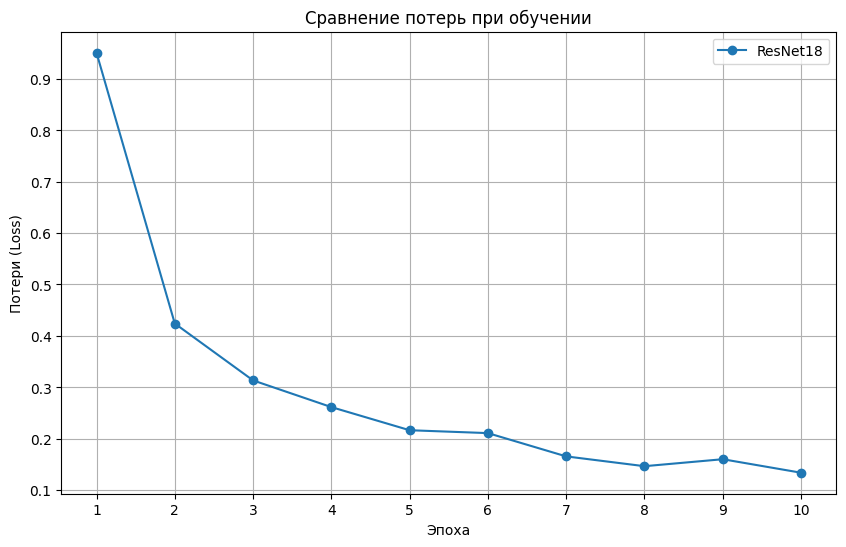

In [58]:
# Построение графика
plt.figure(figsize=(10, 6))
for model_name in model_names:
    if model_name in df_losses.columns:
        plt.plot(df_losses.index+1, df_losses[model_name], label=model_name, marker='o')

plt.xlabel('Эпоха')
plt.ylabel('Потери (Loss)')
plt.title('Сравнение потерь при обучении')
plt.legend()
plt.grid(True)
plt.xticks(range(1, num_epochs+1))
plt.show()

In [59]:
# Вывод финальных результатов
print("\nФинальные потери после обучения:")
final_losses = {name: losses[-1] for name, losses in results.items()}
for name, loss in final_losses.items():
    print(f"{name}: {loss:.4f}")


Финальные потери после обучения:
ResNet18: 0.1337


Попытки применения других популярных архитектур (VGG16, Inception v3, DenseNet161) оказались неудачными из-за их внутренней структуры, предполагающей входные изображения значительно большего размера (≥64×64).

Это подчеркивает важность соответствия архитектуры характеристикам данных.